# EDA: Million Song Dataset + Second Hand Covers Dataset
- Explore million song dataset from https://www.kaggle.com/datasets/undefinenull/million-song-dataset-spotify-lastfm/data
- Explore second hand dataset from http://millionsongdataset.com/secondhand/
- Create spectrograms, plot waveforms, explore available audio and meta data.
- Write script functions to generate and plot data that we need
- Explore size of dataset we will need and potential need for cloud compute

In [1]:
import numpy as np
import pandas as pd
import requests
import io
from IPython.display import Audio, display
import librosa
import librosa.display
import matplotlib.pyplot as plt
import os
import re

### Parsing the Dataset
- What data do we have?
- Does it include access to audio files?
- Can we create spectrograms?

In [2]:
music_info_df = pd.read_csv('/kaggle/input/million-song-dataset-spotify-lastfm/Music Info.csv')

In [3]:
print(f'Empty Spotify Previews: {sum(music_info_df.spotify_preview_url.isna())}')

Empty Spotify Previews: 0


In [4]:
test_df = music_info_df[:5].copy()
test_df

,track_id,name,artist,spotify_preview_url,spotify_id,tags,genre,year,duration_ms,danceability,...,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
0,TRIOREW128F424EAF0,Mr. Brightside,The Killers,https://p.scdn.co/mp3-preview/4d26180e6961fd46...,09ZQ5TmUG8TSL56n0knqrj,"rock, alternative, indie, alternative_rock, in...",NaN,2004,222200,0.355,...,1,-4.360,1,0.0746,0.001190,0.000000,0.0971,0.240,148.114,4
1,TRRIVDJ128F429B0E8,Wonderwall,Oasis,https://p.scdn.co/mp3-preview/d012e536916c927b...,06UfBBDISthj1ZJAtX4xjj,"rock, alternative, indie, pop, alternative_roc...",NaN,2006,258613,0.409,...,2,-4.373,1,0.0336,0.000807,0.000000,0.2070,0.651,174.426,4
2,TROUVHL128F426C441,Come as You Are,Nirvana,https://p.scdn.co/mp3-preview/a1c11bb1cb231031...,0keNu0t0tqsWtExGM3nT1D,"rock, alternative, alternative_rock, 90s, grunge",RnB,1991,218920,0.508,...,4,-5.783,0,0.0400,0.000175,0.000459,0.0878,0.543,120.012,4
3,TRUEIND128F93038C4,Take Me Out,Franz Ferdinand,https://p.scdn.co/mp3-preview/399c401370438be4...,0ancVQ9wEcHVd0RrGICTE4,"rock, alternative, indie, alternative_rock, in...",NaN,2004,237026,0.279,...,9,-8.851,1,0.0371,0.000389,0.000655,0.1330,0.490,104.560,4
4,TRLNZBD128F935E4D8,Creep,Radiohead,https://p.scdn.co/mp3-preview/e7eb60e9466bc3a2...,01QoK9DA7VTeTSE3MNzp4I,"rock, alternative, indie, alternative_rock, in...",RnB,2008,238640,0.515,...,7,-9.935,1,0.0369,0.010200,0.000141,0.1290,0.104,91.841,4


### Defining Useful Functions
- With the idea of eventually having some scripts to create our dataset, we write functions to get audio from links, play the audio, and make various plots

In [5]:
# Function to return the audio
def get_audio(row):
    url = row.spotify_preview_url
    response = requests.get(url)
    audio_data = io.BytesIO(response.content)
    return audio_data

# Play the audio in jupyter
def play_audio(row):
    display(Audio(get_audio(row).read(), autoplay=True))

# Make/display/save plots of waveform and spectrogram
def make_audio_plots(row):
    fig, ax = plt.subplots(1, 2, figsize=(15, 5))
    # Get amplitude vs time waveform
    audio_data = get_audio(row)
    y, sr = librosa.load(audio_data, sr=None)
    librosa.display.waveshow(y, sr=sr, ax=ax[0])
    ax[0].set(title='Amplitude vs Time', xlabel='Time (s)', ylabel='Amplitude')

    # Get mel spectrogram of song
    S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
    S_DB = librosa.power_to_db(S, ref=np.max)
    img = librosa.display.specshow(S_DB, sr=sr, x_axis='time', y_axis='mel', ax=ax[1])
    fig.colorbar(img, ax=ax[1], format='%+2.0f dB')
    ax[1].set(title='Mel Spectrogram')
    plt.suptitle(f"{row['name']} by {row.artist}", fontweight='bold', fontsize=18)

    # Adjust layout and save the combined plot as an image file
    plt.tight_layout()
    plt.savefig('amplitude_and_spectrogram.png')
    plt.show()

In [15]:
test_row = test_df.iloc[1,:].copy()

In [7]:
play_audio(test_row)

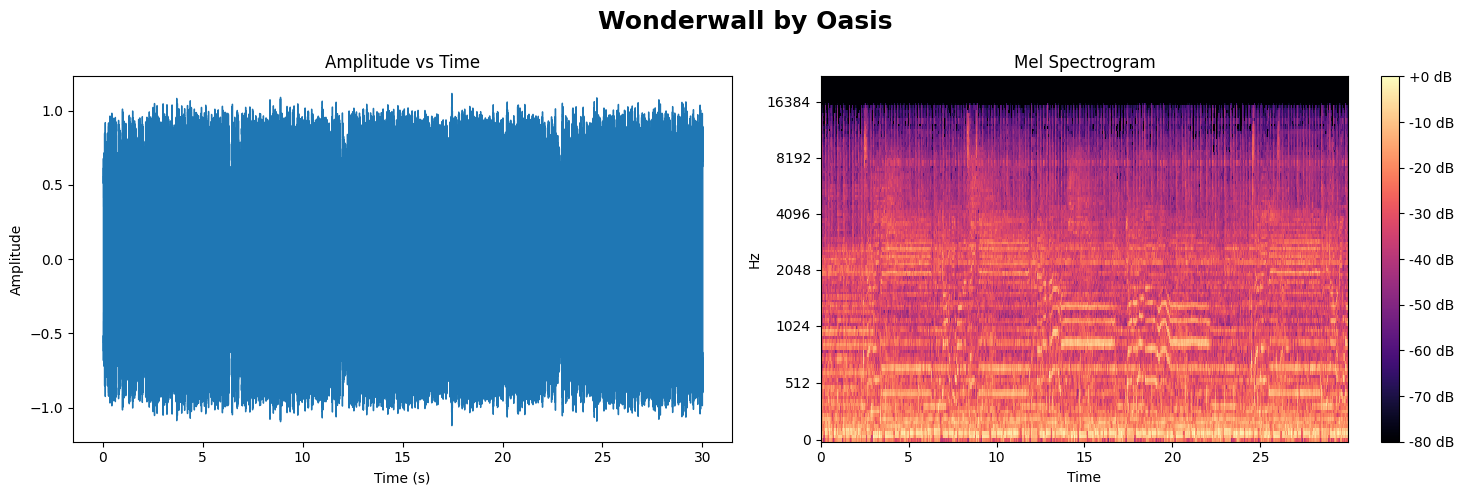

In [9]:
make_audio_plots(test_row)

In [6]:
# Function to get the mel spectrogram for each song in each row of a dataframe
def get_spectrograms(row):
    audio_data = get_audio(row)
    y, sr = librosa.load(audio_data, sr=None)
    S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
    S_DB = librosa.power_to_db(S, ref=np.max)
    return S_DB

In [49]:
# Test how long it will take to generate spectograms
import time
test_df = music_info_df[:5].copy()

start_time = time.time()
test_df['mel_spec'] = test_df.apply(get_spectrograms, axis=1)
end_time = time.time()
elapsed_time = end_time - start_time

print(f"Elapsed time: {elapsed_time} seconds")

# Track Memory Usage of these data points
memory_usage_by_column = test_df.memory_usage(deep=True)
total_memory_usage = memory_usage_by_column.sum()
total_memory_usage_mb = total_memory_usage / (1024 * 1024)
print(f"\nTotal memory usage of DataFrame: {total_memory_usage_mb:.2f} MB")

Elapsed time: 1.1320774555206299 seconds

Total memory usage of DataFrame: 6.31 MB


To load the spectrogram of of 5 entries took t=1.13s and space x=6.31MB. The total dataframe is 50,683 rows meaning n = 50683/5 = 10,136:
   - Estimated Time: 1.13s x 10136 = 11,454s = 190 min = 3.18 hours
   - Estimated Space: 63,958 MB = 63 GB
   
We'll need to split this up in to jobs, use something like pyspark with a cloud database or something else. Next, we need to figure out how big the second hand data set is.   

## Getting the Corresponding MP3 Files 
- Write function to get proper MP3 files for each row to process
- Compare to how long it took to get the spectrograms using the spotify links

In [11]:
# Find total number of mp3 files
def count_mp3_files(base_path):
    mp3_count = 0
    for root, dirs, files in os.walk(base_path):
        for file in files:
            if file.endswith('.mp3'):
                mp3_count += 1
    return mp3_count

base_path = "/kaggle/input/million-song-dataset-spotify-lastfm/MP3-Example/"
total_mp3_files = count_mp3_files(base_path)
print(f"Total number of .mp3 files: {total_mp3_files}")

Total number of .mp3 files: 1500


In [12]:
# Compare to the number of spotify previews we had before
music_info_df.spotify_preview_url.count()

50683

In [7]:
# Function to get file path of audio applied to each row of df
def get_audio_file_path(row):
    # If the genre is present, use that if not we have to search
    if row.genre:
        file_path = f"/kaggle/input/million-song-dataset-spotify-lastfm/MP3-Example/{row.genre}/{row.genre}-{row.track_id}.mp3"
        if os.path.exists(file_path):
            return file_path 
    # If no genre listed, search through all directories
    else:
        base_path = "/kaggle/input/million-song-dataset-spotify-lastfm/MP3-Example/"
        for root, dirs, files in os.walk(base_path):
            for file in files:
                if file.endswith(f"-{row.track_id}.mp3"):
                    return os.path.join(root, file)

    return file_path

In [8]:
test_df['mp3_path'] = test_df.apply(get_audio_file_path, axis=1)
test_df

,track_id,name,artist,spotify_preview_url,spotify_id,tags,genre,year,duration_ms,danceability,...,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,mp3_path
0,TRIOREW128F424EAF0,Mr. Brightside,The Killers,https://p.scdn.co/mp3-preview/4d26180e6961fd46...,09ZQ5TmUG8TSL56n0knqrj,"rock, alternative, indie, alternative_rock, in...",NaN,2004,222200,0.355,...,-4.360,1,0.0746,0.001190,0.000000,0.0971,0.240,148.114,4,/kaggle/input/million-song-dataset-spotify-las...
1,TRRIVDJ128F429B0E8,Wonderwall,Oasis,https://p.scdn.co/mp3-preview/d012e536916c927b...,06UfBBDISthj1ZJAtX4xjj,"rock, alternative, indie, pop, alternative_roc...",NaN,2006,258613,0.409,...,-4.373,1,0.0336,0.000807,0.000000,0.2070,0.651,174.426,4,/kaggle/input/million-song-dataset-spotify-las...
2,TROUVHL128F426C441,Come as You Are,Nirvana,https://p.scdn.co/mp3-preview/a1c11bb1cb231031...,0keNu0t0tqsWtExGM3nT1D,"rock, alternative, alternative_rock, 90s, grunge",RnB,1991,218920,0.508,...,-5.783,0,0.0400,0.000175,0.000459,0.0878,0.543,120.012,4,/kaggle/input/million-song-dataset-spotify-las...
3,TRUEIND128F93038C4,Take Me Out,Franz Ferdinand,https://p.scdn.co/mp3-preview/399c401370438be4...,0ancVQ9wEcHVd0RrGICTE4,"rock, alternative, indie, alternative_rock, in...",NaN,2004,237026,0.279,...,-8.851,1,0.0371,0.000389,0.000655,0.1330,0.490,104.560,4,/kaggle/input/million-song-dataset-spotify-las...
4,TRLNZBD128F935E4D8,Creep,Radiohead,https://p.scdn.co/mp3-preview/e7eb60e9466bc3a2...,01QoK9DA7VTeTSE3MNzp4I,"rock, alternative, indie, alternative_rock, in...",RnB,2008,238640,0.515,...,-9.935,1,0.0369,0.010200,0.000141,0.1290,0.104,91.841,4,/kaggle/input/million-song-dataset-spotify-las...


In [25]:
play_audio(test_df.iloc[0,:])

**NOTE:** It seems faster/more efficient to grab the MP3s, but the spotify links are much more plentiful. We may need to download all of these clips and create our own dataset of size 50,683

## Second Hand Dataset
- Contains 18,196 entries of songs grouped into covers/re-recordings. Subset of dataset above.
- http://millionsongdataset.com/secondhand/
- Explore the groups of cover songs to get set of similar songs for triplet loss (potentially)
- What sort of data do we have to train on?
- Parsing the text files to see if we have all the tracks we need

In [9]:
def parse_text_file(file_path):
    with open(file_path, 'r') as file:
        lines = file.readlines()
    
    # Parse through each line to create rows of info about cover songs
    data = []
    current_row = []
    for line in lines:
        line = line.strip()
        if line.startswith('#'):
            continue
        elif line.startswith('%'):
            if current_row:
                data.append(current_row)
            current_row = [line]
        else:
            current_row.append(line)
    if current_row:
        data.append(current_row)

    # Create dataframe from the extracted data
    df = pd.DataFrame(data, columns=['work_data'] + [f'cover_{i}' for i in range(1, max(len(row) for row in data))])
    
    # Go through the first column, get rid of %, keep only song title
    df['name'] = df['work_data'].str.replace('%', '').str.extract(r'(?<=,)([^,]*$)')[0].str.strip()
    df.drop(columns=['work_data'], inplace=True)
    
    # Separate into cover_i, artist_i, and performance_i
    return df

def preprocess_columns(df):
    # From each cover, separate into 3 columns of track_id_i, artist_id_i, performance_id_i
    cover_cols = [f'cover_{i}' for i in range(1, max(len(row) for row in data))]
    suffixes = ['track_id', 'artist_id', 'performance_id']
    
    # Go through the first column, get rid of %, keep only song title
    df['name'] = df['work_data'].str.replace('%', '').str.extract(r'(?<=,)([^,]*$)')[0].str.strip()
    df.drop(columns=['work_data'], inplace=True)
    
    # Separate into cover_i, artist_i, and performance_i
    for col in df.columns:
        # Only look at columns with cover info
        if col.startswith('cover_'):
            # Create new df split on <SEP> token
            split_cols = df[col].str.split('<SEP>', expand=True)
            new_col_names = [f'{suffix}_{col.split("_")[1]}' for suffix in suffixes]

            # Rename the new columns with a prefix based on the original column name
            split_cols.columns = new_col_names
            # Drop the original column and concatenate the new columns
            df = df.drop(columns=[col]).join(split_cols)
    return processed_df

In [13]:
file_path = '/kaggle/input/second-hand-data/second_hand_data_train.txt'
covers_df = parse_text_file(file_path)
covers_df.head()

,cover_1,cover_2,cover_3,cover_4,cover_5,cover_6,cover_7,cover_8,cover_9,cover_10,...,cover_39,cover_40,cover_41,cover_42,cover_43,cover_44,cover_45,cover_46,cover_47,name
0,TRPYNNL12903CAF506<SEP>ARXJJSN1187B98CB37<SEP>...,TRFYRVZ128F92EF998<SEP>ARNUFGE1187B9B7881<SEP>...,TRXAJXI128F4267A92<SEP>AR7K9W71187B9AF065<SEP>...,TRMONTS128F427FF78<SEP>ARHYUI71187FB48366<SEP>...,TRGSXCN128F9320D4B<SEP>ARZEAO01187B998042<SEP>...,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,My Sweet Lord
1,TRTRNUX128F93297EF<SEP>AR31EL21187B98A723<SEP>...,TRKQBVB128C7196AED<SEP>AR8L6W21187B9AD317<SEP>...,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,These Things Will Keep Me Loving You
2,TRBKHJE128F931F762<SEP>AROHGM71187B98ED9E<SEP>...,TRNOHZD128C719668F<SEP>ARTG85X1187B99D1F5<SEP>...,TRTMZVE128F92DF6FB<SEP>ART9VTZ1187FB48DDC<SEP>...,TRMFHKO128F426E4C6<SEP>ARUIHX41187B98BE59<SEP>-1,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,Take Me In Your Arms (Rock Me A Little While)
3,TRYCGBR128F428256C<SEP>ARLQ1IL1187FB3C77A<SEP>...,TRWQUEV12903CB3AD3<SEP>AROSQW61187FB5330B<SEP>...,TRSGOFX128F4267A45<SEP>AR7K9W71187B9AF065<SEP>...,TRHHBEI12903CF8A4A<SEP>ARKMSNH1187FB44DEB<SEP>...,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,Come Softly To Me
4,TRBQEKU128F428C1B3<SEP>ARLHO5Z1187FB4C861<SEP>...,TRFLJNQ128F14A8388<SEP>ART93VS1187FB5828A<SEP>...,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,No Sleep Till Brooklyn


### Merging Datasets
- Merge every song with a cover where we have it. Need to get similarity scores

In [15]:
# Merge on track_id = cover_1
song_and_covers_df = pd.merge(test_df, covers_df, left_on='track_id', right_on='cover_1', how='inner')
song_and_covers_df.head()

,track_id,name_x,artist,spotify_preview_url,spotify_id,tags,genre,year,duration_ms,danceability,...,cover_39,cover_40,cover_41,cover_42,cover_43,cover_44,cover_45,cover_46,cover_47,name_y


In [34]:
# Check for empty values in work_data
df.name.unique()

array(['My Sweet Lord', 'These Things Will Keep Me Loving You',
       'Take Me In Your Arms (Rock Me A Little While)', ...,
       "you just haven't earned it yet baby", "you're aging well",
       'your cheating heart'], dtype=object)